## Генератор траекторий Геометрического Винеровского процесса

Геометрический Винеровский процесс (далее GBM) - случ. процесс, в котором логарифм случайной величины (сечения) ведёт себя как обычное Броуновское движение (т.е. является Винеровским процессом)


Вывод решения опирается на Лемму Ито, полный вывод можно [найти здесь](https://www.quantstart.com/articles/Geometric-Brownian-Motion/). Он согласется с [формулой из Википедии](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)

Для генерации Винеровского процесса (Броуновского движения) воспользуемся теоремой о том, что оно приближается случайными блужданиями:
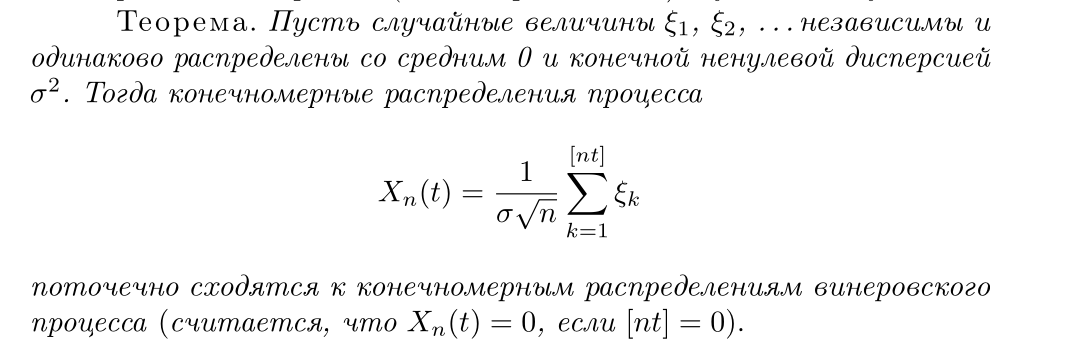

~~Upd. Формула с целой частью оказалась неинтерпретируемой и там из более простых соображений следует (свойства Винеровского процесса: что он Марковский и как распределены приращения) следует такой же результат. Так что теорема неактуальна, будет просто как общий теор. результат~~

~~Случайные величины $\xi_i$ будем брать из $\mathcal{N}{(0, 1)}$, потому что эмпирически шум в большинстве случаев нормален.~~ Дисперсию из теоремы со скрина можно самостоятельно задать параметром `random_walk_scale`

В классе броуновского движения сначала реализуем Винеровский процесс, потом воспользуемся им для реализации GBM.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [35]:
class BrownianMotion:
    def __init__(self, drift = 1, diffusion = 1, scale = 1, n_points = 1000):
        self.drift_rate = drift  # кф-т дрейфа геом. процесса
        self.variance_rate = diffusion  # кф-т диффузии геом. процесса
        self.random_walk_scale = scale  # стандартное отклонение для случ. блужданий
        self.n_iter = n_points  # кол-во точек, в которых моделируем траекторию

    def random_walk(self, t, num_trajectories = 1):
        dt = t / (self.n_iter - 1)
        
        random_increments = np.random.normal(loc = 0, 
                                             scale = self.random_walk_scale * np.sqrt(dt), 
                                             size = (num_trajectories, self.n_iter - 1))
        
        W = np.cumsum(random_increments, axis = 1)
        
        W = np.column_stack((np.zeros(num_trajectories), W))
        
        return W

    def geometric_brownian_motion(self, S_0, t, num_trajectories=1):
        '''
        Ф-я возвращает аналит. формулу для геом. винеровского процесса
        '''
        time = np.linspace(0, t, self.n_iter)
        W = self.random_walk(t, num_trajectories)
        return S_0 * np.exp((self.drift_rate - self.variance_rate ** 2 * 0.5) * time + self.variance_rate * W)

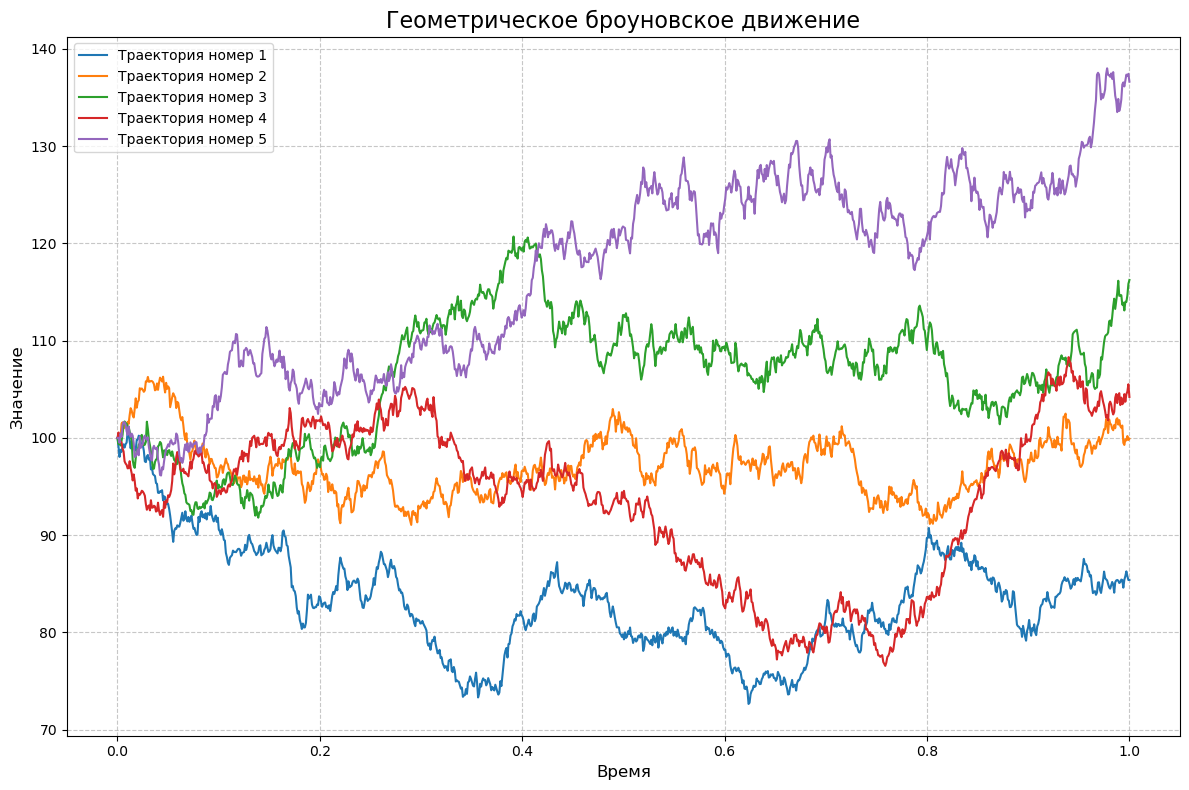

In [37]:
bm = BrownianMotion(drift = 0.1, diffusion = 0.2, scale = 1, n_points = 1000)

S_0 = 100
T = 1
num_paths = 5  # кол-во траекторий

t = np.linspace(0, T, bm.n_iter)

trajectories = bm.geometric_brownian_motion(S_0, T, num_paths)

plt.figure(figsize=(12, 8))

for i in range(num_paths):
    plt.plot(t, trajectories[i], label=f'Траектория номер {i+1}')

plt.title('Геометрическое броуновское движение', fontsize=16)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Европейских опционы с помощью Монте-Карло, сравнение с Блеком-Шоулзом

Под Монте-Карло тут подразумевается тот самый М-К для приближённого интегрирования, который круче чем метод прямоугольников. Сходимость М-К составляет $O(\frac{1}{\sqrt{N}})$, где $N$ - это количество точек. Алгоритм:

1. Написанным генератором генерим много траекторий. Функция `geometric_brownian_motion` из прошлой ячейки вторым аргументом принимает момент времени `T`, то есть можем найти стоимость актива в этот момент времени. При необходимости ещё дисконтируем эту стоимость на какой-то процент (рисковая ставка или безрисковая).
2. Усредням результаты, среднее и будет ответом (вспомним, что ровно то же самое мы делаем и в методе М-К)
3. Полученное число надо ещё сравнить с числом, полученным из формулы Блека-Шоулза

In [38]:
def price_european_option_mc(S_0, K, r, T, bm_instance, n_simulations = 1000, option_type = 'call'):
    """
    Метод Монте-Карло 
    K - цена исполнения опциона
    r - процентная ставка (мб безрисковая, мб нет)
    option_type - тип опциона. Если 'call', то право купить, если 'put', то право продать
    """
    
    bm_instance.drift_rate = r
    
    trajectories = bm_instance.geometric_brownian_motion(S_0, T, n_simulations)

    S_T = trajectories[:, -1]
    
    if option_type == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)
    
    option_price = np.mean(payoffs) * np.exp(-r * T)
    
    return option_price

In [39]:
def black_scholes(S0, K, r, sigma, T, option_type = 'call'):
    """
    Просто формула Блека-Шоулза с Википедии
    """
    
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S0 * sps.norm.cdf(d1) - K * np.exp(-r * T) * sps.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * sps.norm.cdf(-d2) - S0 * sps.norm.cdf(-d1)
        
    return price

100%|██████████| 25/25 [00:00<00:00, 2939.49it/s]


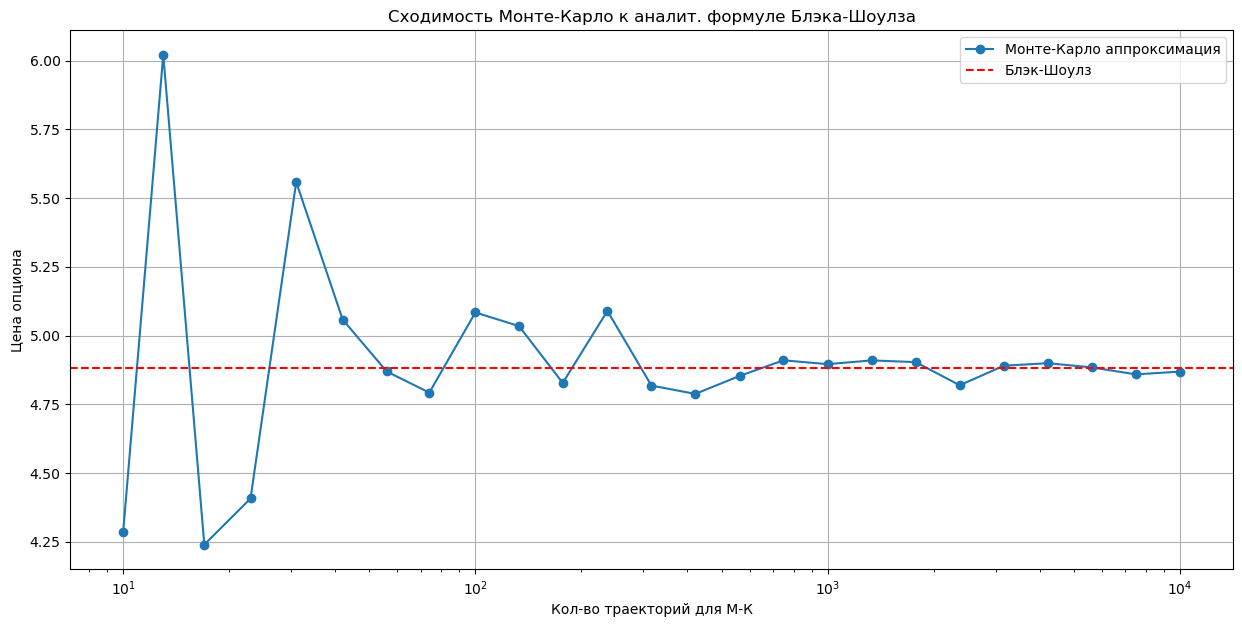

In [40]:
S0, K, r, sigma, T = 100, 100, 0.05, 0.02, 1

bm = BrownianMotion(drift = r, diffusion = sigma, scale = 1, n_points = 2)
bs_price = black_scholes(S0, K, r, sigma, T, option_type = 'call')

n_simulations_list = np.logspace(1, 4, 25, dtype = int) # сетка от 10^1 до 10^4 
mc_prices = []

for n_sim in tqdm(n_simulations_list):
    mc_price = price_european_option_mc(S0, K, r, T, bm, n_simulations = n_sim, option_type = 'call')
    mc_prices.append(mc_price)

plt.figure(figsize = (15, 7))
plt.plot(n_simulations_list, mc_prices, label = "Монте-Карло аппроксимация", marker = 'o')
plt.axhline(y=bs_price, color = 'r', linestyle = '--', label = "Блэк-Шоулз")
plt.xscale("log")
plt.xlabel("Кол-во траекторий для М-К")
plt.ylabel("Цена опциона")
plt.title("Сходимость Монте-Карло к аналит. формуле Блэка-Шоулза")
plt.legend()
plt.grid()
plt.show()

### Подводка к американским опционам. Regression Based Monte-Carlo для целочисленного поиска УМО.

Рассмотрим задачу $$ \mathbb{E}(W_{t} \mid W_s = x)$$ 
Для Винеровского процесса эта задача имеет аналит. решение, но если процесс сложнее, то аналит. формула мб очень сложной. Поэтому учимся решать это целочисленно с помощью `Regression Based Monte-Carlo`. 

Идейно: за таргет делаем $W_{t}$, далее делаем себе трейн: рассмотрим базис $[1 + x + x^2 + x^3 ... ]$, будем обучать линрег на этом базисе с таргетом $W_{t}$. Базис может быть любым: полиномы, многочлены Фурье, [многочлены Лагерра](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%9B%D0%B0%D0%B3%D0%B5%D1%80%D1%80%D0%B0), [многочлены Эрмита](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%AD%D1%80%D0%BC%D0%B8%D1%82%D0%B0) и тп.
На этом базисе обучаем линрег на наш таргет и успех нам даёт следующий факт:

**Утв.** УМО минимизирует MSE

Док-во

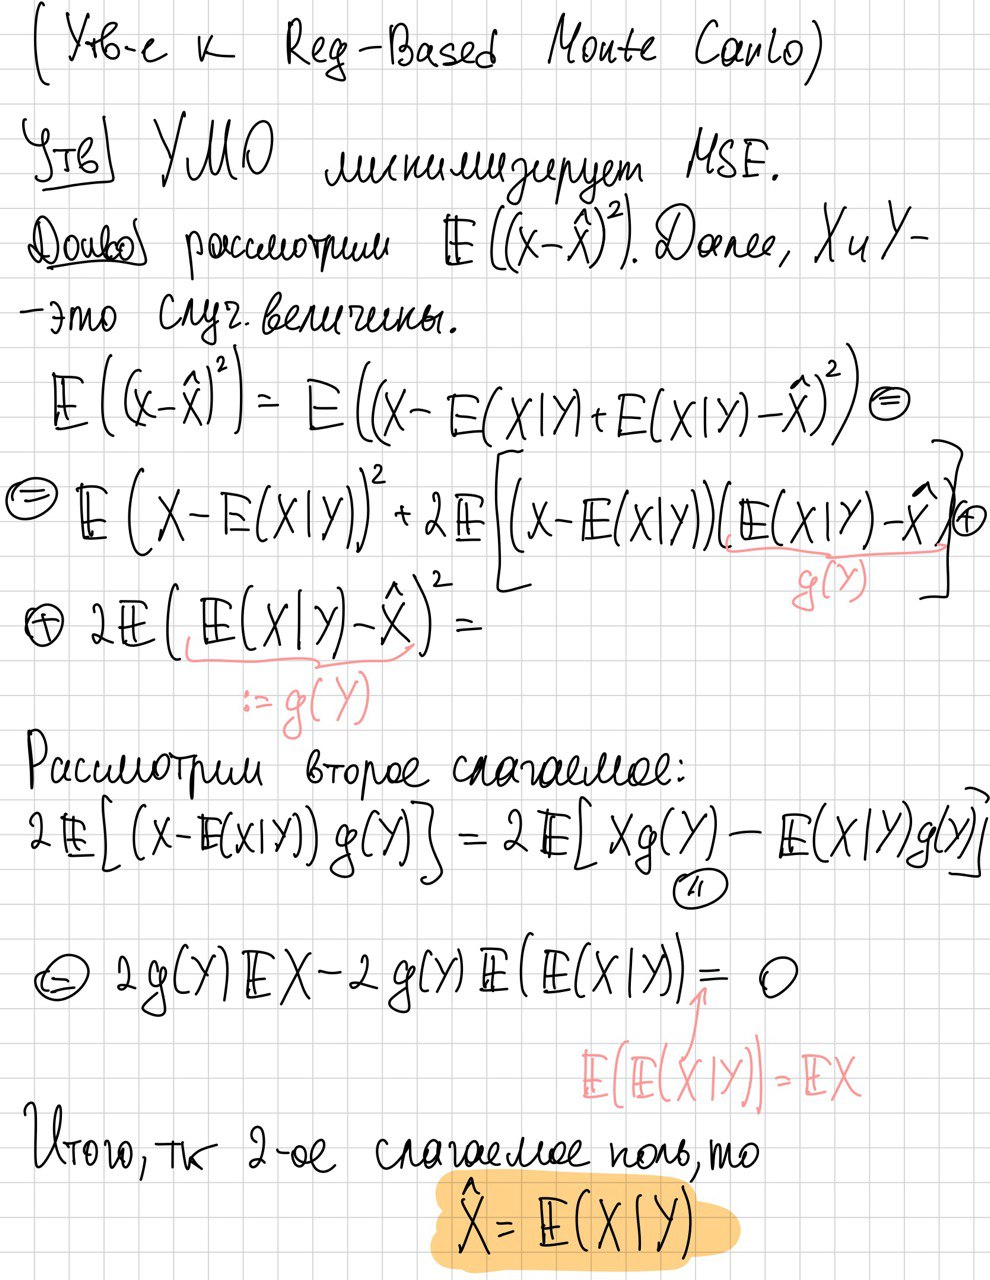

И посмотрим на общий результат для $$\mathbb{E}(W_{t} \mid W_s = a)$$

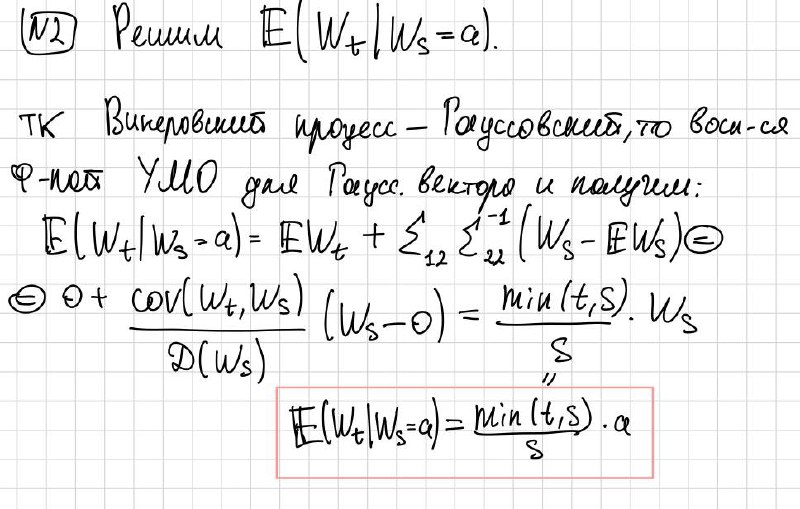

In [182]:
def create_basis(W_s, degree = 3):
    basis = np.column_stack([W_s ** i for i in range(1, degree + 1)])
    return basis

def analytical_umo(W_s, t, s):
    return (min(t, s) / s) * W_s

def predict_umo(model, a, degree = 3):
    a_basis = np.array([a ** i for i in range(1, degree + 1)]).reshape(1, -1)
    return model.intercept_ + np.dot(a_basis, model.coef_)

def regression_monte_carlo(t, s, bm, num_trajectories = 10000, n_points = 1000, degree = 3):
    T = max(t, s)
    W = bm.random_walk(T, num_trajectories)
    
    t_idx = int(t / T * (n_points - 1))
    s_idx = int(s / T * (n_points - 1))
    
    W_t = W[:, t_idx]
    W_s = W[:, s_idx].reshape(-1, 1)
    
    X = create_basis(W_s, degree = degree)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(X, W_t)
    
    return model, W_s, W_t

In [195]:
def analyze_basis_degree_dependency(t, s, a, bm, num_trajectories = 10000, n_points = 100, min_degree = 3, max_degree = 10):
    degrees = list(range(min_degree, max_degree + 1))
    predictions = []

    analytical_value = analytical_umo(a, t, s)
    
    for degree in degrees:
        model, _, _ = regression_monte_carlo(t, s, bm, num_trajectories, n_points, degree)
        
        pred = predict_umo(model, a, degree)
        predictions.append(pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, predictions, marker = 'o', label = "Предсказание регрессии", color = "blue")
    plt.axhline(y=analytical_value, color = "red", linestyle = "--", label = "Аналитическое решение")
    plt.xlabel("Размер базиса")
    plt.ylabel(f"$E(W_t | W_s = {a})$")
    plt.title(f"Результат reg M-K в з-ти от размера базиса (t = {t}, s = {s}, a = {a})")
    plt.legend()
    plt.grid(True)
    plt.show()

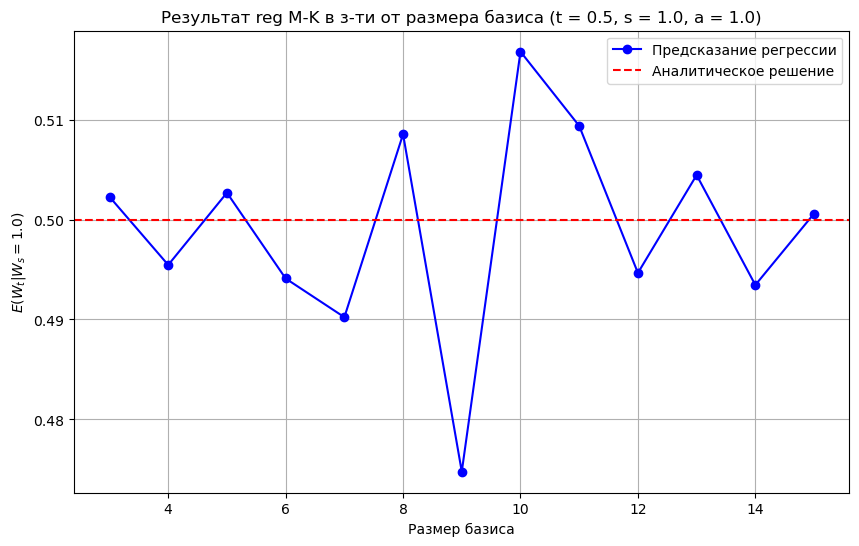

In [196]:
bm = BrownianMotion(scale = 1, n_points = 1000)
t = 0.5
s = 1.0
a = 1.0
num_trajectories = 10000
analyze_basis_degree_dependency(t, s, a, bm, num_trajectories, 1000, min_degree = 3, max_degree = 15)